In [71]:
# Required Imports
from battle_simulation.Battle import Battle, experiment_winner
from battle_simulation.Pokemon import Pokemon
from ipywidgets import *
from IPython.display import display, clear_output
from battle_simulation.battle_common import battle_log_msg
import os
from pathlib import Path
import pandas as pd
import json
import random
import logging
import copy
from traitlets import traitlets
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

In [55]:
# New child class for user input being from Jupyter widgets instead of just user input


class UserBattleJupyter(Battle):
    def __init__(self, Pokemon1, Pokemon2):
        super().__init__(Pokemon1, Pokemon2)

    def battle_execute_turn_user_input(self):
        """
        Runs one turn of the battle through using user input, read in through the ipywidgets button
        User pokemon is Pokemon1
        
        This function is overwritten from the parent class
        """

        # Get the moves from user click
        user_input_move_options_dict = {
            k: list(first_mon_moveset[k].keys())[0] for k in first_mon_moveset
        }
        res_ls = [items[0].value, items[1].value, items[2].value, items[3].value]

        chosen_move_str = [x for x in res_ls if x is not False][
            0
        ]  # extract the chosen move
        user_choice = list(user_input_move_options_dict.keys())[
            list(user_input_move_options_dict.values()).index(chosen_move_str)
        ]
        print(
            "Selected move: {} was used".format(
                user_input_move_options_dict[user_choice]
            )
        )

        if self.Pokemon1.speed >= self.Pokemon2.speed:
            #             print("Next turn: ")
            self.Pokemon1.use_move(self.Pokemon2, int(user_choice))
            if self.Pokemon2.hp > 0:  # if Pokemon2 has fainted from the previous move
                self.Pokemon2.use_move(self.Pokemon1)
        else:
            #             print("Next turn: ")
            self.Pokemon2.use_move(self.Pokemon1)
            if self.Pokemon1.hp > 0:
                self.Pokemon1.use_move(self.Pokemon2, int(user_choice))

        if self.Pokemon1.hp == 0 or self.Pokemon2.hp == 0:
            winner = self.Pokemon1.name if self.Pokemon1.hp > 0 else self.Pokemon2.name
            print("The battle is finished.  {} is the winner.".format(winner))
        else:
            print("Please select another move from the widget buttons.")

In [59]:
# Required functions

def on_button_clicked(b):
    for i in range(len(items)):
        items[i].value = False
    with output:
        b.value = b.description
        battle.battle_execute_turn_user_input()


class LoadedButton(widgets.Button):
    """A button that can holds a value as a attribute."""

    # from https://stackoverflow.com/questions/45188464/return-output-of-the-function-executed-on-click

    def __init__(self, value=None, *args, **kwargs):
        super(LoadedButton, self).__init__(*args, **kwargs)
        # Create the value attribute.
        self.add_traits(value=traitlets.Any(value))

Pokemon to use from the following options ['Mewtwo', 'Mew', 'Charizard', 'Blastoise', 'Pikachu']: Pikachu


INFO:root:>>> Battle started between: Pikachu and Blastoise


Choose the move that Pikachu will use from the following: 


Output()

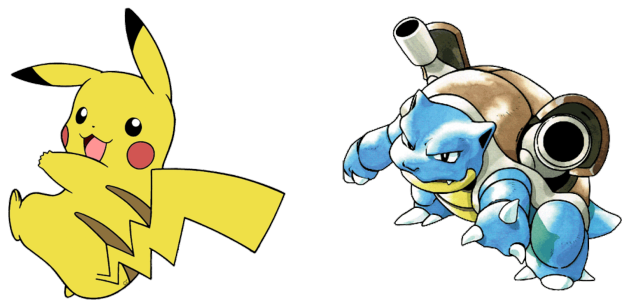

In [75]:
# Get the logger
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Read in the required raw data
mfs_path = os.path.join(str(Path(os.path.realpath("__file__")).parents[3]), "mfs")
pokemon_df = pd.read_csv(os.path.join(mfs_path, "pokedex_data.csv"), index_col=2)
pokemon_df.drop("Unnamed: 0", axis=1, inplace=True)

status_effect_df = pd.read_csv(
    os.path.join(mfs_path, "status_effects.csv"), index_col=0
)

moveset_json = os.path.join(mfs_path, "moveset.json")
with open(moveset_json) as json_file:
    moveset_data = json.load(json_file)

# First Pokemon, user chooses from input
first_mon_name = input(
    "Pokemon to use from the following options {}: ".format(list(moveset_data.keys()))
)
first_mon_moveset = moveset_data[first_mon_name]
first_mon = Pokemon(first_mon_name, pokemon_df, first_mon_moveset, status_effect_df)

# Randomize the second one from available choices from moveset dict
# cannot be the same pokemon that was chosen as the first one
ls_choices = copy.deepcopy(list(moveset_data.keys()))
ls_choices.remove(first_mon_name)
second_mon_name = random.choice(ls_choices)
second_mon_moveset = moveset_data[second_mon_name]
second_pokemon = Pokemon(
    second_mon_name, pokemon_df, second_mon_moveset, status_effect_df
)


# Initiating the battle class
battle = UserBattleJupyter(first_mon, second_pokemon)
battle_log_msg('Battle started between: {0} and {1}'.format(first_mon.name, second_pokemon.name))

# Display images of the battling pokemon
# Images from https://www.clipartmax.com/
%matplotlib inline
# figure size in inches optional
rcParams['figure.figsize'] = 11 ,8

img_path = os.path.join(str(Path(os.path.realpath("__file__")).parents[3]), "images")
first_mon_img_path = os.path.join(img_path, '{}.png'.format(first_mon_name))
second_mon_img_path = os.path.join(img_path, '{}.png'.format(second_mon_name))
first_mon_img = mpimg.imread(first_mon_img_path)
second_mon_img = mpimg.imread(second_mon_img_path)

# display images
fig, ax = plt.subplots(1,2)
ax[0].axis('off')
ax[1].axis('off')
ax[0].imshow(first_mon_img);
ax[1].imshow(second_mon_img);

# Widgets to be displayed for the move options
user_input_move_options_dict = {
    k: list(first_mon_moveset[k].keys())[0] for k in first_mon_moveset
}
words = [list(first_mon_moveset[k].keys())[0] for k in first_mon_moveset]
items = [LoadedButton(description=w) for w in words]
left_box = VBox([items[0], items[1]])
right_box = VBox([items[2], items[3]])
HBox([left_box, right_box])

# all button values are initialized to False
for i in range(len(items)):
    items[i].value = False

output = widgets.Output()

print(
    "Choose the move that {name} will use from the following: ".format(
        name=first_mon.name
    )
)

display(HBox([left_box, right_box]), output)

# Move actions on button clicks
items[0].on_click(on_button_clicked)
items[1].on_click(on_button_clicked)
items[2].on_click(on_button_clicked)
items[3].on_click(on_button_clicked)